## *Install Libraries*

In [1]:
!pip install tensorflow==2.17.0
!pip install gpflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.1 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tensorflow 2.17.0 which is incompatible.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.17.0 which is incompatible.
tf-keras 2.1

## *Import Libraries*

In [2]:
import numpy as np
import tensorflow as tf
import gpflow
from tensorflow.keras.datasets import fashion_mnist
from gpflow.models import SVGP
from gpflow.mean_functions import Constant
from gpflow.kernels import RBF
from gpflow.likelihoods import MultiClass
from tensorflow.keras.utils import to_categorical
from gpflow.utilities import print_summary
from gpflow.ci_utils import reduce_in_tests
from typing import Optional, Tuple

2024-10-03 14:28:56.009811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 14:28:56.038019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 14:28:56.038069: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## *Load Dataset*

In [3]:
# Cargar y preprocesar los datos de FashionMNIST
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(-1, 28*28) / 255.0
X_test = X_test.reshape(-1, 28*28) / 255.0

# Convertir etiquetas a one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_train_integers = np.argmax(y_train, axis=1).reshape(-1, 1)


batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_integers))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
train_dataset = train_dataset.shuffle(buffer_size=60000).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=60000).batch(batch_size)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## *Model and Kernel*

In [4]:
X_train.shape

(60000, 784)

In [5]:
# Kernel RBF
kernel = gpflow.kernels.SquaredExponential()

# Modelo GPR
inducing_variable = X_train[:500]  # Usar 500 puntos de inducción
model = gpflow.models.SVGP(kernel=kernel,
                           likelihood=gpflow.likelihoods.MultiClass(10),
                           inducing_variable=inducing_variable,
                           num_latent_gps=10)
print('kernel hyperparameter initial point\n',model.kernel.lengthscales)

kernel hyperparameter initial point
 <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.0>


In [6]:
print_summary(model)

╒═════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤════════════════╤═════════╤═══════════════════════╕
│ name                            │ class     │ transform      │ prior   │ trainable   │ shape          │ dtype   │ value                 │
╞═════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪════════════════╪═════════╪═══════════════════════╡
│ SVGP.kernel.variance            │ Parameter │ Softplus       │         │ True        │ ()             │ float64 │ 1.0                   │
├─────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼────────────────┼─────────┼───────────────────────┤
│ SVGP.kernel.lengthscales        │ Parameter │ Softplus       │         │ True        │ ()             │ float64 │ 1.0                   │
├─────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼────────────────┼─────────┼───────────────────────┤
│ SVGP.likelihood.in

## *Train*

In [14]:
batch_size = 64
n_epochs = 200
num_train_data = reduce_in_tests(100)
num_batches_per_epoch = num_train_data // batch_size
data =(X_train , y_train_integers)

In [15]:
# Función para entrenar el modelo
optimizer = tf.optimizers.Adam(learning_rate=1e-3)

@tf.function
def optimization_step(
    model, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        loss = model.training_loss(batch)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

def simple_training_loop(
    model: gpflow.models.SVGP, epochs: int = 1, logging_epoch_freq: int = 10
):
    tf_optimization_step = tf.function(optimization_step)

    batches = iter(train_dataset)
    batches = next(batches)
    for epoch in range(epochs):
        for _ in range(num_batches_per_epoch):
            tf_optimization_step(model, batches)

        epoch_id = epoch + 1
        if epoch_id % logging_epoch_freq == 0:
            tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(data)}")

In [16]:
simple_training_loop(model, epochs=n_epochs, logging_epoch_freq=2)

Epoch 2: ELBO (train) -486613.51469669957
Epoch 4: ELBO (train) -486435.3344530994
Epoch 6: ELBO (train) -486302.57637651416
Epoch 8: ELBO (train) -486218.0729794071
Epoch 10: ELBO (train) -486173.5950016372
Epoch 12: ELBO (train) -486150.5526157375
Epoch 14: ELBO (train) -486134.5348479263
Epoch 16: ELBO (train) -486121.53870926675
Epoch 18: ELBO (train) -486111.0991432376
Epoch 20: ELBO (train) -486101.20192797977
Epoch 22: ELBO (train) -486090.22102304763
Epoch 24: ELBO (train) -486076.36782017513
Epoch 26: ELBO (train) -486058.61391327914
Epoch 28: ELBO (train) -486038.2334332871
Epoch 30: ELBO (train) -486016.90441898233
Epoch 32: ELBO (train) -485994.2998230119
Epoch 34: ELBO (train) -485969.19150243234
Epoch 36: ELBO (train) -485940.9247370047
Epoch 38: ELBO (train) -485909.90447503154
Epoch 40: ELBO (train) -485877.5770072314
Epoch 42: ELBO (train) -485843.66440971295
Epoch 44: ELBO (train) -485806.7167643982
Epoch 46: ELBO (train) -485766.2233579457
Epoch 48: ELBO (train) -485

In [17]:
# Obtener predicciones en el conjunto de prueba
mu, var = model.predict_y(X_test)

# Convertir probabilidades en etiquetas
y_pred_labels = np.argmax(mu, axis=1)

# Convertir y_test desde one-hot encoded a etiquetas (forma 1D)
y_test_labels = np.argmax(y_test, axis=1)

In [18]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

Precisión del modelo: 59.77%


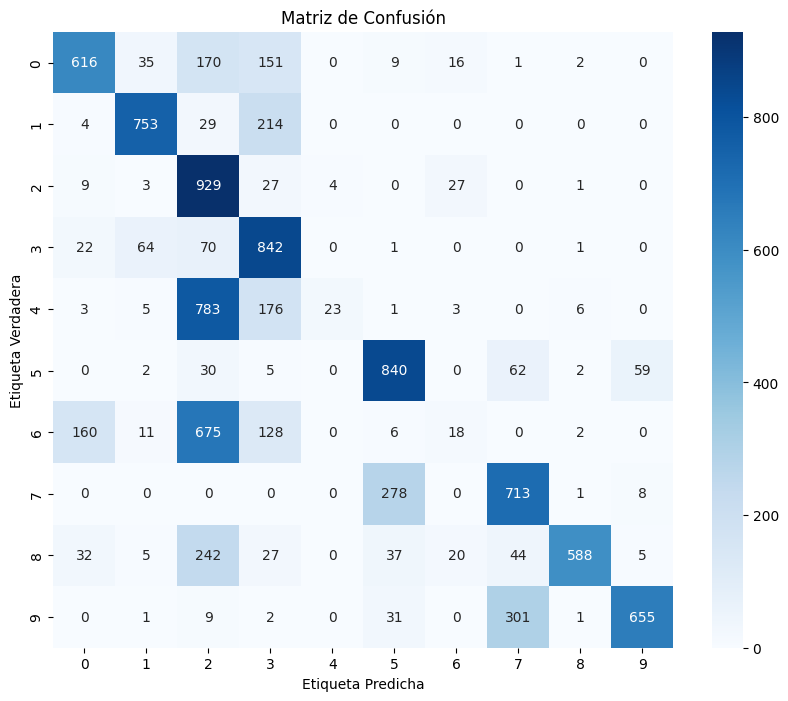

              precision    recall  f1-score   support

           0       0.73      0.62      0.67      1000
           1       0.86      0.75      0.80      1000
           2       0.32      0.93      0.47      1000
           3       0.54      0.84      0.65      1000
           4       0.85      0.02      0.04      1000
           5       0.70      0.84      0.76      1000
           6       0.21      0.02      0.03      1000
           7       0.64      0.71      0.67      1000
           8       0.97      0.59      0.73      1000
           9       0.90      0.66      0.76      1000

    accuracy                           0.60     10000
   macro avg       0.67      0.60      0.56     10000
weighted avg       0.67      0.60      0.56     10000



In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Generar el reporte de clasificación
print(classification_report(y_test_labels, y_pred_labels))

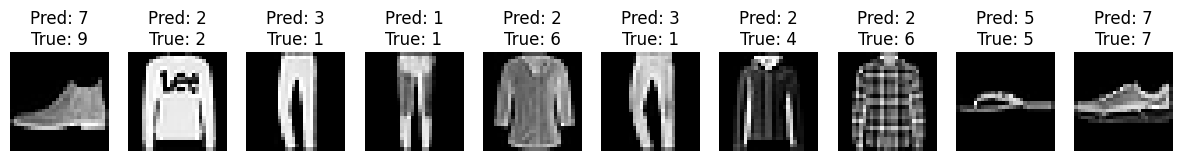

In [20]:
# Visualizar algunas imágenes con predicciones
num_images = 10
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {y_pred_labels[i]}\nTrue: {y_test_labels[i]}")
    plt.axis('off')
plt.show()